<a href="https://colab.research.google.com/github/msa1997/ads-2023/blob/main/ADS_HW11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Diable warnings about max_itr not reached etc.!
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
# Importing necessary libraries
import pandas as pd
import io
import os
import numpy as np
import copy
import pdb
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks
from sklearn.metrics import f1_score
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2, l1, l1_l2
from keras.layers import Dense, Input, Dropout

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

%matplotlib inline
sns.set(color_codes=True)

# Dataset
The Fashion MNIST dataset is a large freely available database of fashion images. It contains 70,000 28x28 grayscale images of fashion products from 10 categories from a dataset of Zalando article images, with 7,000 images per category. The training set consists of 60,000 images and the test set consists of 10,000 images.

Each training and test example is assigned to one of the following labels:

Label Description

*   0 T-shirt/top
*   1 Trouser
*   2 Pullover
*   3 Dress
*   4 Coat
*   5 Sandal
*   6 Shirt
*   7 Sneaker
*   8 Bag
*   9 Ankle boot




# Loading the Dataset
The Fashion MNIST dataset can be loaded directly from Keras.

Since `Transfer Learning` models like `VGG9` and `MobileNetV2` have architectures that have a minimum input size, which is usually a minimum input size of `32×32` , we will change the size of the dataset images from 28×28 pixels to 32×32 pixels from the very beginning.

In [ ]:
import cv2
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Define the new image size (32x32 pixels) and number of channels
new_size = (32, 32)
num_channels = 1  # Grayscale images have 1 channel

# Create an empty array to store resized training images
num_train_samples = x_train.shape[0]
resized_train_images = np.empty((num_train_samples, *new_size, num_channels), dtype=np.uint8)

# Create an empty array to store resized testing images
num_test_samples = x_test.shape[0]
resized_test_images = np.empty((num_test_samples, *new_size, num_channels), dtype=np.uint8)

# Loop through each image in the training set and resize it
for i in range(num_train_samples):
    resized_image = cv2.resize(x_train[i], new_size, interpolation=cv2.INTER_LINEAR)
    resized_train_images[i] = resized_image[:, :, np.newaxis]  # Add the channel dimension

# Loop through each image in the testing set and resize it
for i in range(num_test_samples):
    resized_image = cv2.resize(x_test[i], new_size, interpolation=cv2.INTER_LINEAR)
    resized_test_images[i] = resized_image[:, :, np.newaxis]  # Add the channel dimension

# 'resized_train_images' and 'resized_test_images' now contain the resized training and testing sets
# Each image has a shape of (num_samples, 32, 32, 1)


4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
print(f'Size of Training Set: {resized_train_images.shape}')
print(f'Size of Test Set: {resized_test_images.shape}')

Size of Training Set: (60000, 32, 32, 1)
Size of Test Set: (10000, 32, 32, 1)


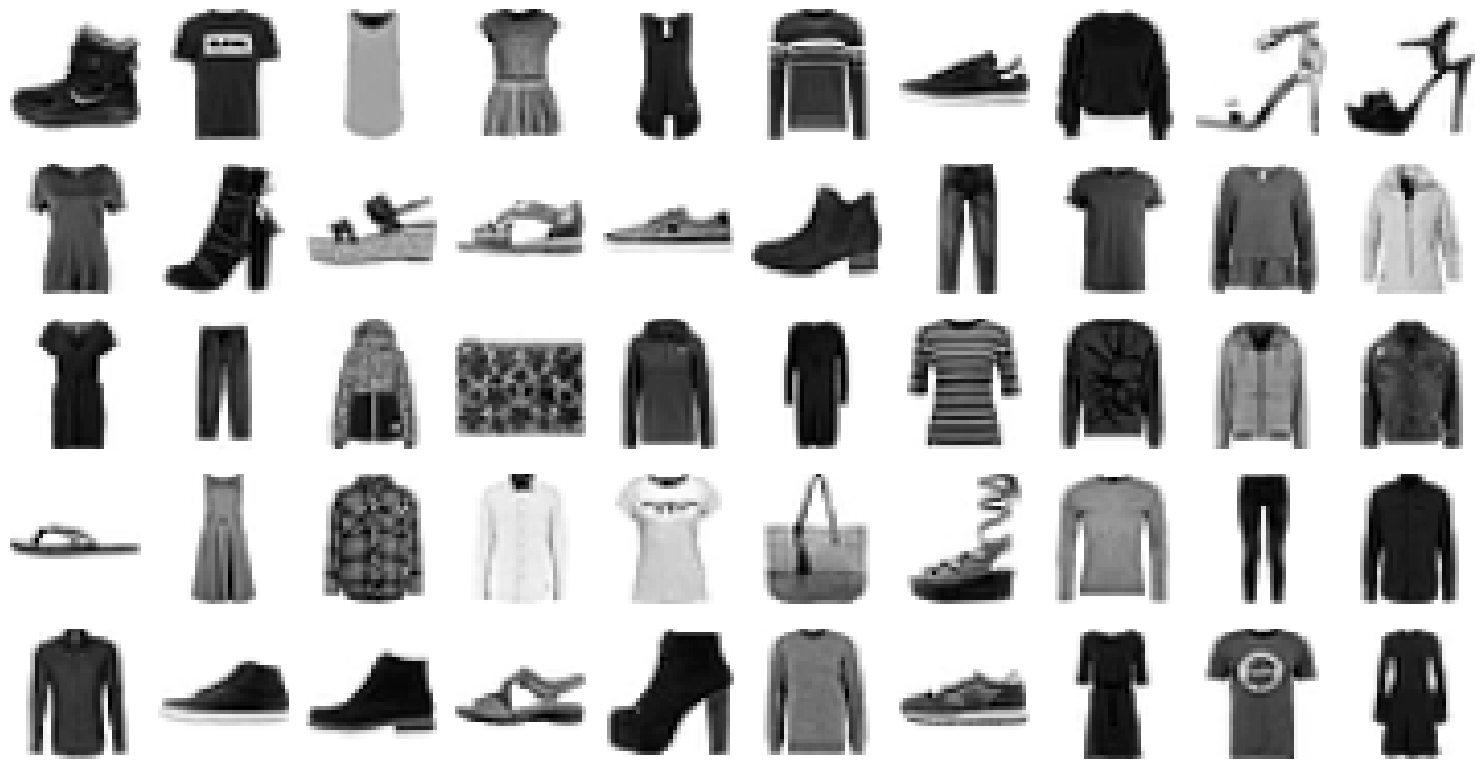

In [ ]:
plt.figure(figsize=(15,8))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(resized_train_images[i].reshape((32,32)),cmap='binary')
    plt.axis("off")
plt.tight_layout()

In [ ]:
class_names = ["T-shirt/top" , "Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]


First, let's check the distribution of classes in the training set:

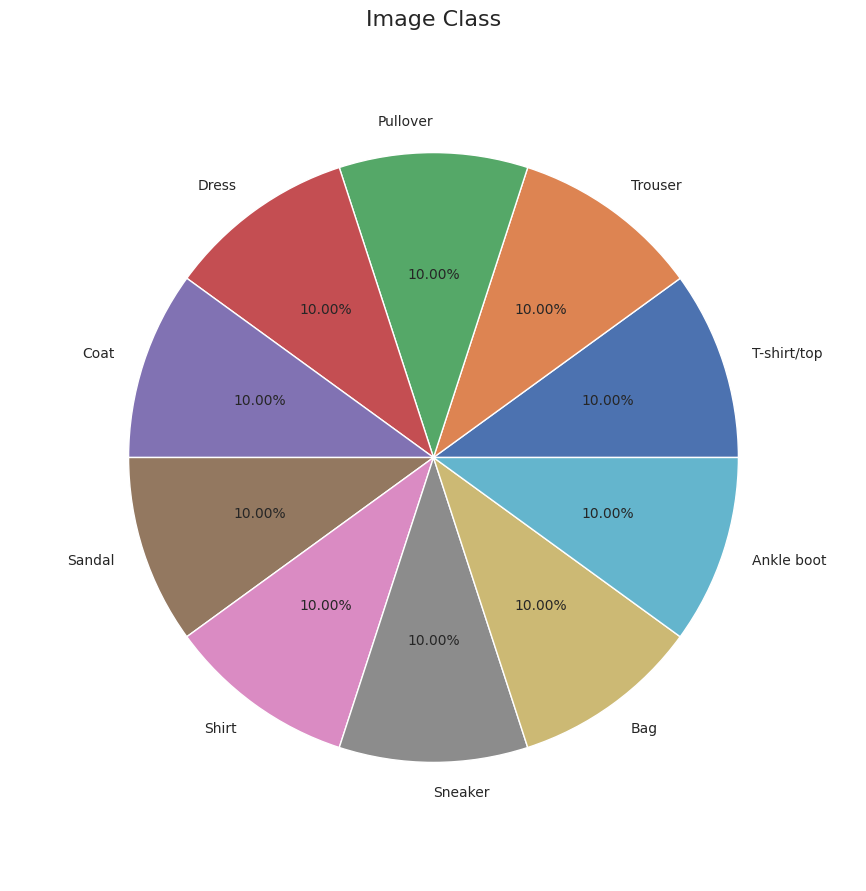

In [ ]:
# Now, let's query the corresponding slice from our main dataframe
y_df = pd.DataFrame(y_train)
selected_labels = class_names
y_df.value_counts().plot(
    kind = 'pie',figsize=(15,11),autopct='%1.2f%%',ylabel='',radius=0.9,labels=selected_labels,fontsize=10)

# Now let's setup the labels, titles and format y axis as percentages
plt.title("Image Class",fontsize=16)
#plt.legend(selected_labels,loc='lower right',fontsize=14)
plt.show()

As you can see and as menstioned earlier, all classes have almost equal amount of samples so the data set is fully balanced!

# Data Preprocessing

Since we want to use Keras API for this homework and the keras models need to receive labels in one-hot-encoding format we do so in cell below.

In [ ]:
resized_X_train = resized_train_images/255.
resized_X_test = resized_test_images/255.

In [ ]:
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
enc = LabelBinarizer()
enc.fit(y_train)

y_train_enc = enc.transform(y_train)

In [ ]:
y_test_enc = enc.transform(y_test)

In [ ]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [ ]:
y_train_enc

array([[0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Convultional Networks With Keras

### Handy Functions (Wrappers)

In [ ]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,          # minimium amount of change to be considered an improvement
    patience=5,              # number of epochs to wait before deciding there is no significant improvement in training
    restore_best_weights=True,
)

We start with the function we use to plot the loss or accuracy (precision/recall) of the model during training. The inputs are:


*   **history:** This is the output history of the keras fit() method
*   **plot_type:** If it is "loss", the training/validation loss will be plotted. Otherwise, the accuracy graph is returned.


In [ ]:
def plot_history(history,plot_type: str='loss'):
  hist_df = pd.DataFrame(history.history)
  plt.figure(figsize=(20,8))
  colors = []
  columns_to_plot = []
  labels = []
  for col_name in hist_df.columns:

    # Define colors
    if 'val' in col_name:
      validation = True
      color_base = 'r'
      label_base = 'Validation'
    else:
      validation = False
      color_base = 'b'
      label_base = 'Training'

    if plot_type == 'loss':
      if 'loss' in col_name:
        labels.append(label_base)
        columns_to_plot.append(col_name)
        colors.append(color_base)
    else:
      if 'loss' in col_name:
        continue
      if 'recall' in col_name:
        color = color_base + '--'
        label = label_base + 'Recall'
      else:
        color = color_base
        label = label_base + 'Precision'

      labels.append(label)
      columns_to_plot.append(col_name)
      colors.append(color)


  for itr in range(0,len(columns_to_plot)):
    plt.plot(hist_df.loc[:, [columns_to_plot[itr]]], colors[itr], label=labels[itr],lw=4)

  plt.ylabel(plot_type)
  plt.xlabel('Epochs')
  plt.legend(loc="best")
  plt.show()

Next, we proceed with a function to create a multi-layered feedforward neural network. The way it works is that we specify the following inputs:

*   hidden_layers: specifies the hidden layers and the structure of the network, with the following conventions
    * `Conv2D_AxB_C_D`: a convolutional layer, with the receptive field (kernel size) of size `AxB`, no. filters of `C` and stride of `D`.
    * `MaxPooling2D_AxB_D`: a max pooling layer, with the receptive field (filter) of size `AxB` and stride of `D`
    * `AveragePooling2D_AxB_D`: an average pooling layer, with the receptive field (filter) of size `AxB` and stride of `D`
    * `Flatten`: the flatten layer,
    * `Dense_N`: a dense layer with `N` neurons.
*   **input_size :** the number of neurons in the input layer. It is equal to `X_train.shape[1]`
*   **activation_func :** it is a string specifying the type of the activation function.
*   **L1_reg :** a real number, which specifies the L1-regualirization coefficient in each layer (the higher it is, the more severe the regularization will be).
*   **L2_reg :** a real number, which specifies the L2-regualirization coefficient in each layer (the higher it is, the more severe the regularization will be).
*   **learning_rate :** a real number, specifying the learning rate in the gradient descent algorithm
*   **learning_rate_decay:** a real number, specifying the decay in the learning rate after a few iterations
*   **dropout_rate :** the rate at which neurons are "dropped-out" during training. If this value is 0, it means we won't have any dropout
*   **weight_initializer :** name of the weight initialization technique used to setup the weights when the algorithm starts.
    
Once given these inputs, the function creates the model according to our specs, compile it and return it as the output.

In [ ]:
from keras.layers import Dense, Input, Dropout, Conv2D, AveragePooling2D, MaxPooling2D, Flatten

In [ ]:
def create_model(conv1_kernel_size = 3,
                 conv1_strides = 1,
                 conv1_filters = 10,

                 pool1_pool_size = 2,
                 pool1_strides = 2,

                 conv2_kernel_size = 5,
                 conv2_strides = 1,
                 conv2_filters = 20,

                 pool2_pool_size = 2,
                 pool2_strides = 1,

                 input_shape=(32, 32, 1), no_classes=10, activation_func='relu',
                 dropout_rate= 0.2, weight_initializer=''
                 ):



  model = Sequential()

  model.add(Input(shape=input_shape))

  model.add(Conv2D(kernel_size=(conv1_kernel_size, conv1_kernel_size),
                   strides= conv1_strides,
                   filters=conv1_filters))

  model.add(MaxPooling2D(pool_size=(pool1_pool_size, pool1_pool_size),
                         strides=pool1_strides))

  model.add(Conv2D(kernel_size=(conv2_kernel_size, conv2_kernel_size),
                   strides= conv2_strides,
                   filters=conv2_filters))

  model.add(MaxPooling2D(pool_size=(pool2_pool_size, pool2_pool_size),
                         strides=pool2_strides))

  model.add(Flatten())

  model.add(Dropout(dropout_rate))

  model.add(Dense(30))

  model.add(Dense(no_classes, activation='softmax'))

  opimizer = tf.keras.optimizers.Adam()

  model.compile(
        loss='categorical_crossentropy',
        optimizer=opimizer,
        metrics=['accuracy'],
        )

  return model

In [ ]:
def convert_predictions(predictions):
  output = np.argmax(predictions,axis=1)
  return output

### k-Fold Wrapper
k-fold cross validation wrapper:

*   **no_folds:** the number of folds we are going to use

*   **plot_results:** if True, the progress of training procedure is displayed and the resulting loss/accuracy is going to be dispayed after each fold is done.

*   **models_params:** this is the dictionry of the parameters we need to pass to the create_model() function above

*   **training_params:** these are the parameters used to tune the training algorithm


Once the inputs are specified, the function loops over the specified number of folds, and return the average and standard deviation of the accuracy over the validation set.

In [ ]:
def kfold_validation(no_folds: int=3, plot_results: bool=True,
                     model_params: dict={},training_params: dict={}):
  validation_set_accuracy = []
  models = []

  if plot_results:
    verbose=2
  else:
    verbose=0

  itr = 0
  kf = KFold(n_splits=no_folds)
  for train_index, val_index in kf.split(resized_X_train,y_train_enc):
    train_set, y_train_set = resized_X_train[train_index], y_train_enc[train_index]
    val_set,y_val = resized_X_train[val_index], y_train_enc[val_index]

    # First, create a new model

    model = create_model(**model_params)


    # Finally, let's fit the model
    history = model.fit(train_set, y_train_set,
                      validation_data=(val_set,y_val),
                      callbacks=[early_stopping],
                      verbose=verbose,
                      **training_params,
                      )


    # Finally, let's
    pred_val = model.predict(val_set)
    del model
    keras.backend.clear_session()
    f1 = f1_score(convert_predictions(y_val), convert_predictions(pred_val), average='weighted')

    validation_set_accuracy.append(f1)

    # Plot the results
    if plot_results:
      plot_history(history,plot_type='acc')


  # Convert to numpy array
  validation_set_accuracy = np.array(validation_set_accuracy)

  # Return the best model (as an example)
  ind = np.argmax(validation_set_accuracy)

  # Print the reults
  if plot_results:
    print('Average F1-Score over validation set is %.2f' %validation_set_accuracy.mean())
    print('STD of F1-Score over validation set is %.2f' %validation_set_accuracy.std())
  return validation_set_accuracy.mean(),validation_set_accuracy.std()

In [ ]:
kfold_params = {
    'no_folds': 3,
    'plot_results': False,
    'model_params': {
      'conv1_kernel_size': 3,
      'conv1_strides': 1,
      'conv1_filters': 10,

      'pool1_pool_size': 2,
      'pool1_strides': 2,

      'conv2_kernel_size': 5,
      'conv2_strides': 1,
      'conv2_filters': 20,

      'pool2_pool_size': 2,
      'pool2_strides': 1
  },
  'training_params': {
    'batch_size': 64,
    'epochs': 6
  }
}

In [ ]:
def evaluate_efect_param(parameter_type: str='kfold', parameter_name: str='', values_list: list=[]):
  scores_val = []
  scores_test = []
  for val in values_list:

      if parameter_type == 'kfold':
        kfold_params[parameter_name] = val
      elif parameter_type == 'model_params':
        kfold_params['model_params'][parameter_name] = val
      elif parameter_type == 'training_params':
        kfold_params['training_params'][parameter_name] = val

      validation_set_accuracy_mean,validation_set_accuracy_std = kfold_validation(**kfold_params)

      scores_val.append(validation_set_accuracy_mean)

      print('Val: %s, Validation Score: %.3f' %(str(val),validation_set_accuracy_mean))

  # Get the best result
  ind = np.argmax(scores_val)
  best_val = values_list[np.argmax(scores_val)]

  return best_val

In [ ]:
kfold_params['plot_results'] = False

In [ ]:
keras.backend.clear_session()

### Building and Training the Model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 10)        100       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 10)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 20)        5020      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 20)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2000)              0         
                                                                 
 dropout (Dropout)           (None, 2000)              0

In [ ]:
history = model.fit(resized_X_train, y_train_enc,
                    batch_size = 16,
                    epochs = 15,
                    validation_split=0.2,
                    callbacks=[early_stopping]
                    )

Epoch 1/15
3000/3000 [==============================] - 19s 5ms/step - loss: 0.4826 - accuracy: 0.8304 - val_loss: 0.4000 - val_accuracy: 0.8585
Epoch 2/15
3000/3000 [==============================] - 13s 4ms/step - loss: 0.3659 - accuracy: 0.8721 - val_loss: 0.3538 - val_accuracy: 0.8749
Epoch 3/15
3000/3000 [==============================] - 13s 4ms/step - loss: 0.3296 - accuracy: 0.8826 - val_loss: 0.3220 - val_accuracy: 0.8853
Epoch 4/15
3000/3000 [==============================] - 13s 4ms/step - loss: 0.3095 - accuracy: 0.8882 - val_loss: 0.3303 - val_accuracy: 0.8823
Epoch 5/15
3000/3000 [==============================] - 13s 4ms/step - loss: 0.2966 - accuracy: 0.8945 - val_loss: 0.3189 - val_accuracy: 0.8867
Epoch 6/15
3000/3000 [==============================] - 13s 4ms/step - loss: 0.2839 - accuracy: 0.8981 - val_loss: 0.3069 - val_accuracy: 0.8922
Epoch 7/15
3000/3000 [==============================] - 15s 5ms/step - loss: 0.2752 - accuracy: 0.9029 - val_loss: 0.3102 - val_ac

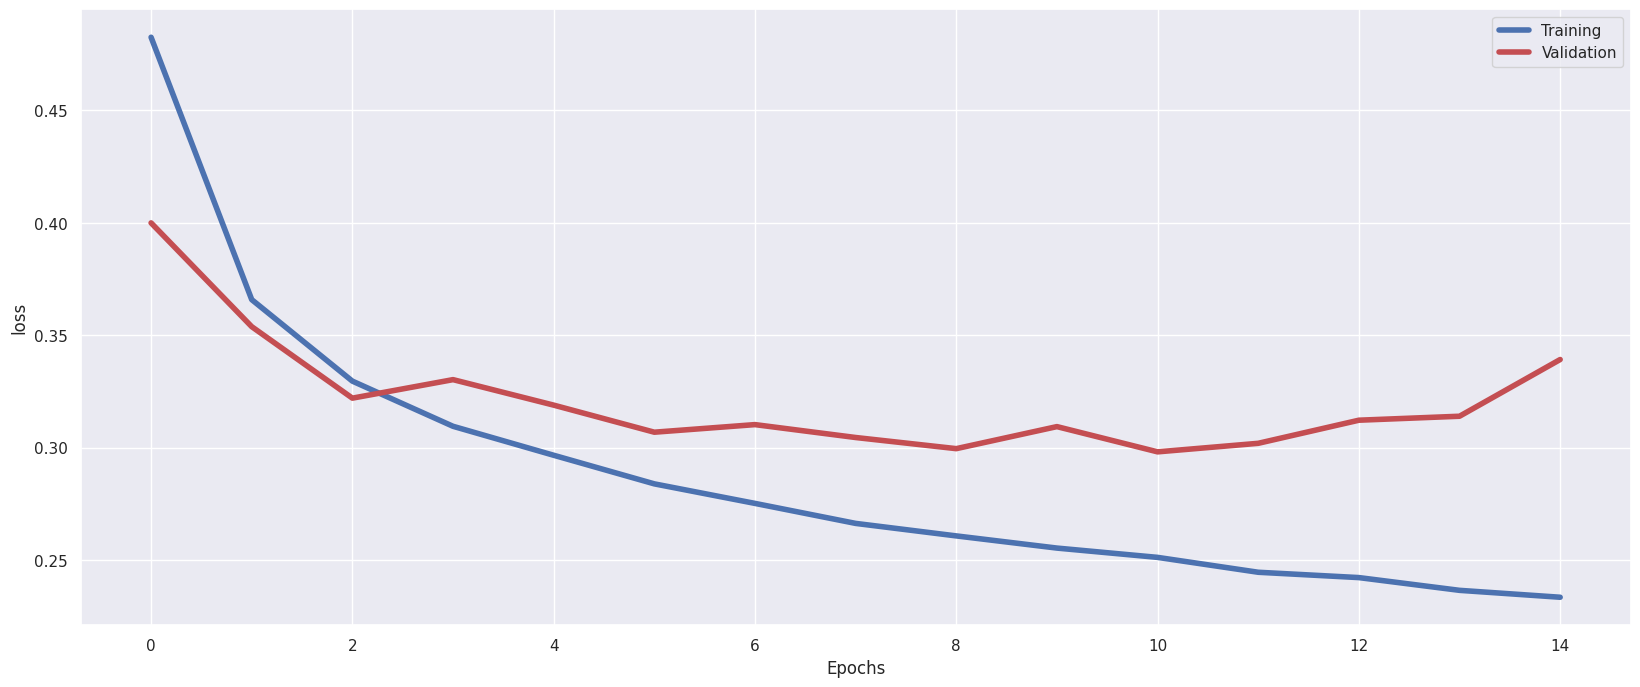

In [ ]:
plot_history(history,plot_type='loss')

In [ ]:
def convert_predictions(predictions):
  output = np.argmax(predictions,axis=1)
  return output

In [ ]:
predictions = model.predict(resized_X_test)

313/313 [==============================] - 1s 2ms/step


In [ ]:
convert_predictions(predictions)

array([9, 2, 1, ..., 8, 1, 5])

In [ ]:
print('Weighted F1-Score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))

Weighted F1-Score is 0.88


In [ ]:
from sklearn.metrics import top_k_accuracy_score

In [ ]:
print('Top-2 Accuracy =  %.2f' %top_k_accuracy_score(y_test, predictions, k=2))

Top-2 Accuracy =  0.97


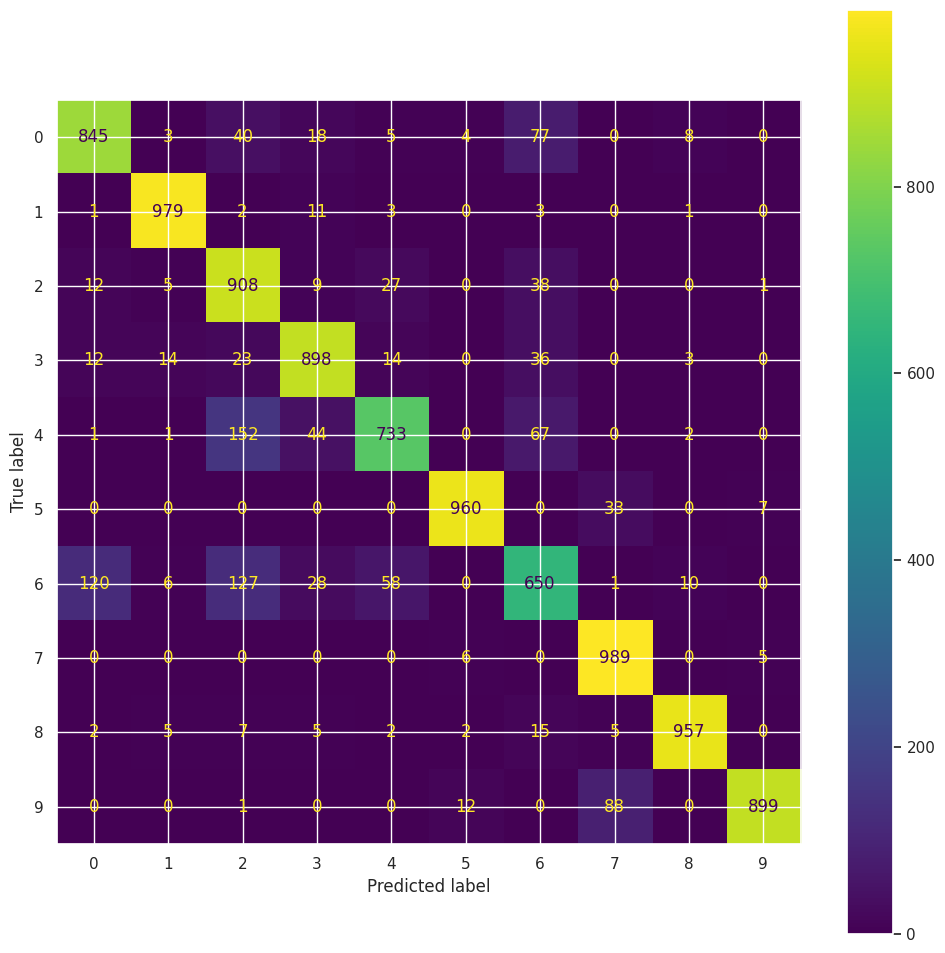

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(y_test, convert_predictions(predictions),ax=ax)
plt.show()

# Tuning the kernel size

### Layer 1

Tuning conv1_kernel_size

In [ ]:
%%time
kernel_sizes = [1, 2, 3, 4]
best_conv1_kernel_size = evaluate_efect_param(parameter_type='model_params',parameter_name='conv1_kernel_size', values_list=kernel_sizes)
kfold_params['model_params']['conv1_kernel_size'] = best_conv1_kernel_size

625/625 [==============================] - 1s 2ms/step
Val: 1, Validation Score: 0.880
625/625 [==============================] - 1s 2ms/step
Val: 2, Validation Score: 0.883
625/625 [==============================] - 1s 2ms/step
Val: 3, Validation Score: 0.885
625/625 [==============================] - 1s 2ms/step
Val: 4, Validation Score: 0.883
CPU times: user 4min 12s, sys: 27.6 s, total: 4min 40s
Wall time: 4min 31s


Tuning conv1_strides

In [ ]:
%%time
conv1_strides = [1, 2]
best_conv1_strides = evaluate_efect_param(parameter_type='model_params',parameter_name='conv1_strides', values_list=conv1_strides)
kfold_params['model_params']['conv1_strides'] = best_conv1_strides

625/625 [==============================] - 1s 2ms/step
Val: 1, Validation Score: 0.886
625/625 [==============================] - 2s 2ms/step
Val: 2, Validation Score: 0.850
CPU times: user 2min 5s, sys: 13.4 s, total: 2min 18s
Wall time: 2min 20s


Tuning pool1_pool_size

In [ ]:
%%time
pool1_pool_size = [1, 2, 3]
best_pool1_pool_size = evaluate_efect_param(parameter_type='model_params',parameter_name='pool1_pool_size', values_list=pool1_pool_size)
kfold_params['model_params']['pool1_pool_size'] = best_pool1_pool_size

625/625 [==============================] - 1s 2ms/step
Val: 1, Validation Score: 0.880
625/625 [==============================] - 2s 3ms/step
Val: 2, Validation Score: 0.888
625/625 [==============================] - 1s 2ms/step
Val: 3, Validation Score: 0.880
CPU times: user 3min 7s, sys: 20.7 s, total: 3min 28s
Wall time: 3min 24s


Tuning pool1_strides

In [ ]:
%%time
pool1_strides = [1, 2]
best_pool1_strides = evaluate_efect_param(parameter_type='model_params',parameter_name='pool1_strides', values_list=pool1_strides)
kfold_params['model_params']['pool1_strides'] = best_pool1_strides

625/625 [==============================] - 1s 2ms/step
Val: 1, Validation Score: 0.891
625/625 [==============================] - 2s 4ms/step
Val: 2, Validation Score: 0.889
CPU times: user 2min 7s, sys: 14 s, total: 2min 21s
Wall time: 2min 15s


Tuning conv1_filters (number of extracted patterns)

In [ ]:
%%time
conv1_filters = np.linspace(5, 20, 5, dtype=int)
print(conv1_filters)
best_conv1_filters = evaluate_efect_param(parameter_type='model_params',parameter_name='conv1_filters', values_list=conv1_filters)
kfold_params['model_params']['conv1_filters'] = best_conv1_filters

[ 5  8 12 16 20]
625/625 [==============================] - 1s 2ms/step
Val: 5, Validation Score: 0.887
625/625 [==============================] - 1s 2ms/step
Val: 8, Validation Score: 0.889
625/625 [==============================] - 2s 3ms/step
Val: 12, Validation Score: 0.890
625/625 [==============================] - 1s 2ms/step
Val: 16, Validation Score: 0.893
625/625 [==============================] - 1s 2ms/step
Val: 20, Validation Score: 0.889
CPU times: user 5min 26s, sys: 34.4 s, total: 6min 1s
Wall time: 6min 18s


### Layer 2

Tuning conv2_kernel_size

In [ ]:
%%time
kernel_sizes = [2, 3, 4, 5]
best_conv2_kernel_size = evaluate_efect_param(parameter_type='model_params',parameter_name='conv2_kernel_size', values_list=kernel_sizes)
kfold_params['model_params']['conv2_kernel_size'] = best_conv2_kernel_size

625/625 [==============================] - 1s 2ms/step
Val: 2, Validation Score: 0.892
625/625 [==============================] - 1s 2ms/step
Val: 3, Validation Score: 0.891
625/625 [==============================] - 1s 2ms/step
Val: 4, Validation Score: 0.891
625/625 [==============================] - 1s 2ms/step
Val: 5, Validation Score: 0.892
CPU times: user 4min 18s, sys: 27.3 s, total: 4min 45s
Wall time: 4min 59s


Tuning conv2_strides

In [ ]:
%%time
conv2_strides = [1, 2]
best_conv2_strides = evaluate_efect_param(parameter_type='model_params',parameter_name='conv2_strides', values_list=conv2_strides)
kfold_params['model_params']['conv2_strides'] = best_conv2_strides

625/625 [==============================] - 1s 2ms/step
Val: 1, Validation Score: 0.890
625/625 [==============================] - 1s 2ms/step
Val: 2, Validation Score: 0.892
CPU times: user 2min 9s, sys: 14.4 s, total: 2min 23s
Wall time: 2min 25s


Tuning pool2_pool_size

In [ ]:
%%time
pool2_pool_size = [1, 2, 3]
best_pool2_pool_size = evaluate_efect_param(parameter_type='model_params',parameter_name='pool2_pool_size', values_list=pool2_pool_size)
kfold_params['model_params']['pool2_pool_size'] = best_pool2_pool_size

625/625 [==============================] - 1s 2ms/step
Val: 1, Validation Score: 0.887
625/625 [==============================] - 1s 2ms/step
Val: 2, Validation Score: 0.890
625/625 [==============================] - 1s 2ms/step
Val: 3, Validation Score: 0.890
CPU times: user 3min 9s, sys: 20.9 s, total: 3min 30s
Wall time: 3min 34s


Tuning pool2_strides

In [ ]:
%%time
pool2_strides = [1, 2]
best_pool2_strides = evaluate_efect_param(parameter_type='model_params',parameter_name='pool2_strides', values_list=pool2_strides)
kfold_params['model_params']['pool2_strides'] = best_pool2_strides

625/625 [==============================] - 1s 2ms/step
Val: 1, Validation Score: 0.893
625/625 [==============================] - 1s 2ms/step
Val: 2, Validation Score: 0.880
CPU times: user 2min 3s, sys: 13.8 s, total: 2min 17s
Wall time: 2min 11s


Tuning conv2_filters (number of extracted patterns)


In [ ]:
%%time
conv2_filters = np.linspace(10, 30, 5, dtype=int)
print(conv2_filters)
best_conv2_filters = evaluate_efect_param(parameter_type='model_params',parameter_name='conv2_filters', values_list=conv2_filters)
kfold_params['model_params']['conv2_filters'] = best_conv2_filters

[10 15 20 25 30]
625/625 [==============================] - 2s 3ms/step
Val: 10, Validation Score: 0.885
625/625 [==============================] - 1s 2ms/step
Val: 15, Validation Score: 0.890
625/625 [==============================] - 1s 2ms/step
Val: 20, Validation Score: 0.892
625/625 [==============================] - 1s 2ms/step
Val: 25, Validation Score: 0.897
625/625 [==============================] - 2s 2ms/step
Val: 30, Validation Score: 0.896
CPU times: user 5min 16s, sys: 35 s, total: 5min 51s
Wall time: 5min 48s


#### Best model parameters:

In [ ]:
kfold_params['model_params']

{'conv1_kernel_size': 3,
 'conv1_strides': 1,
 'conv1_filters': 16,
 'pool1_pool_size': 2,
 'pool1_strides': 1,
 'conv2_kernel_size': 5,
 'conv2_strides': 2,
 'conv2_filters': 25,
 'pool2_pool_size': 2,
 'pool2_strides': 1}

# Data Augmentation

# Why we use Data Augmentation?

Data augmentation is beneficial for image data and machine learning models for several reasons:


1.   **Increased Dataset Size:** Augmentation techniques generate additional training examples by applying various transformations (e.g., rotations, flips, zooms) to existing images. This effectively increases the size of the training dataset, which helps prevent overfitting and improves model generalization.

2.   **Improved Robustness:** Augmented data exposes the model to a wider range of variations and scenarios that it may encounter in real-world applications. This makes the model more robust and capable of handling diverse input conditions.

3.   **Feature Learning:** Augmentation diversifies the features and patterns the model learns. For instance, by rotating or flipping an image, the model can recognize the same object from different angles, enhancing its ability to generalize across orientations.

4.   **Reduced Memorization:** Data augmentation discourages the model from memorizing the training dataset, as it sees variations of the same images during training. This encourages the model to focus on learning meaningful features and patterns.


5.   **Regularization:** Augmentation acts as a form of regularization, helping prevent overfitting by introducing noise and variability into the training data.


6.   **Addressing Class Imbalance:** In imbalanced datasets, where some classes have fewer samples, augmentation can balance the class distribution by creating synthetic examples of minority classes, which is crucial for classification tasks.



7.   **Enhanced Performance:** Augmentation often leads to better model performance, as it provides the model with more diverse and representative training samples, enabling it to make more accurate predictions on unseen data.


In summary, data augmentation enhances a model's performance and generalization by increasing the dataset size, improving robustness, encouraging feature learning, and mitigating overfitting, ultimately resulting in better model performance on real-world image data.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

We have several options to create new images from our existing images:

*   `rotation_range`: is a value in degrees (0-180), a range within which to randomly rotate pictures
*   `width_shift` and `height_shift`: are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
*   `rescale`:  is a value by which we will multiply the data before any other processing (similar to the approach we used above to divide all pixels by 255, we could have set `rescale` to 1/255. here).
*   `shear_range`: is for randomly applying shearing transformations
*   `zoom_range`: is for randomly zooming inside pictures
*   `horizontal_flip`: is for randomly flipping half of the images horizontally
*   `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        featurewise_center=True,
        featurewise_std_normalization=True,
        fill_mode='nearest',
        validation_split=0.2
        )

In [ ]:
train_iterator = train_datagen.flow(resized_X_train, y_train_enc,subset='training',batch_size=16)
val_iterator = train_datagen.flow(resized_X_train, y_train_enc,subset='validation',batch_size=16)

In [ ]:
history = model.fit_generator(
      train_iterator,
      validation_data=val_iterator,
      callbacks=[early_stopping],
      steps_per_epoch=len(train_iterator),
      validation_steps=len(val_iterator),
      verbose=2,
      epochs=15,
)

Epoch 1/15
3000/3000 - 37s - loss: 1.0702 - accuracy: 0.6175 - val_loss: 1.0292 - val_accuracy: 0.6238 - 37s/epoch - 12ms/step
Epoch 2/15
3000/3000 - 33s - loss: 1.0361 - accuracy: 0.6276 - val_loss: 0.9771 - val_accuracy: 0.6519 - 33s/epoch - 11ms/step
Epoch 3/15
3000/3000 - 37s - loss: 1.0059 - accuracy: 0.6366 - val_loss: 0.9417 - val_accuracy: 0.6634 - 37s/epoch - 12ms/step
Epoch 4/15
3000/3000 - 36s - loss: 0.9929 - accuracy: 0.6438 - val_loss: 0.9616 - val_accuracy: 0.6478 - 36s/epoch - 12ms/step
Epoch 5/15
3000/3000 - 37s - loss: 0.9695 - accuracy: 0.6485 - val_loss: 0.9284 - val_accuracy: 0.6674 - 37s/epoch - 12ms/step
Epoch 6/15
3000/3000 - 34s - loss: 0.9589 - accuracy: 0.6529 - val_loss: 0.9086 - val_accuracy: 0.6781 - 34s/epoch - 11ms/step
Epoch 7/15
3000/3000 - 32s - loss: 0.9502 - accuracy: 0.6559 - val_loss: 0.8944 - val_accuracy: 0.6695 - 32s/epoch - 11ms/step
Epoch 8/15
3000/3000 - 33s - loss: 0.9394 - accuracy: 0.6605 - val_loss: 0.8733 - val_accuracy: 0.6795 - 33s/ep

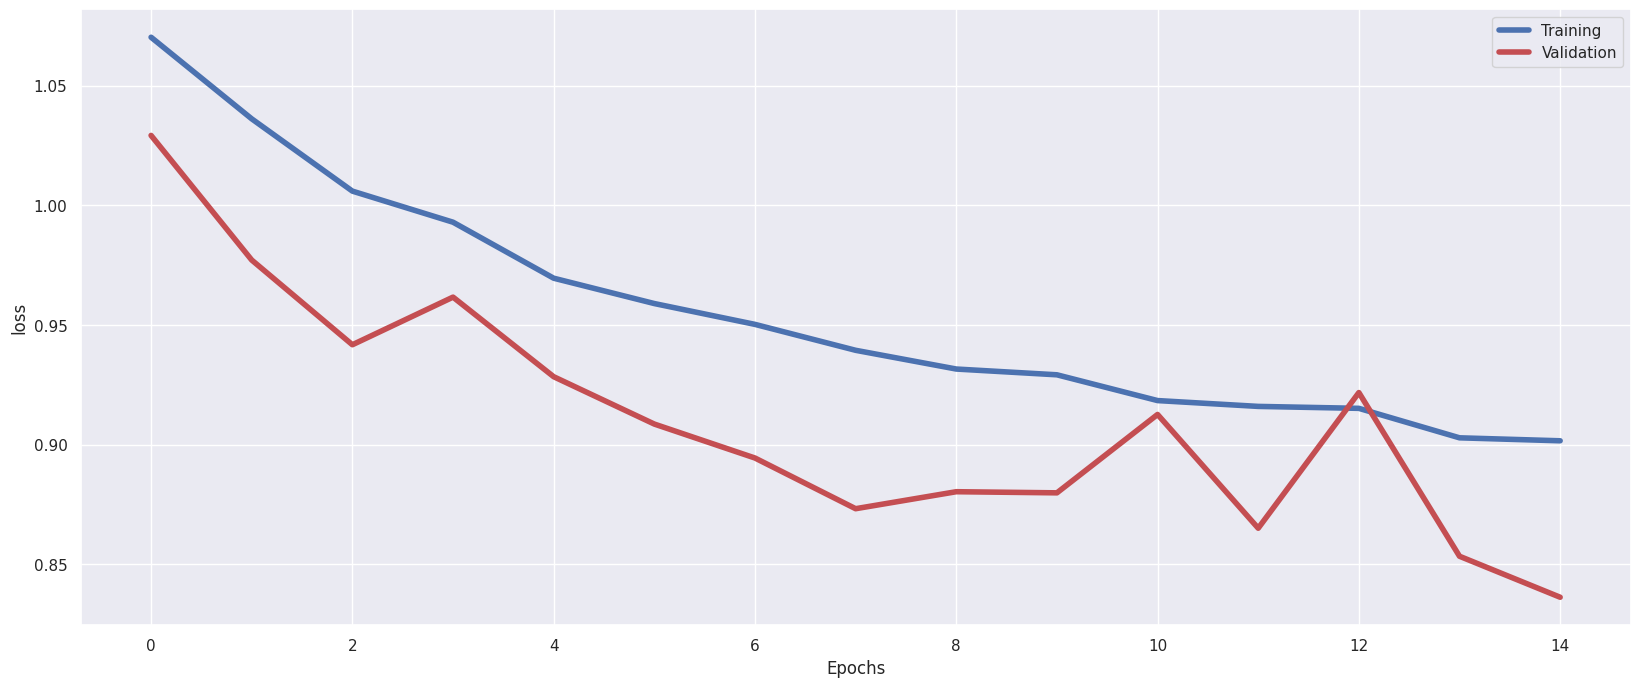

In [ ]:
plot_history(history,plot_type='loss')


The Validation diagram shows that if we increase the number of epochs, the performance of the model will still improve.

In [ ]:
predictions = model.predict(resized_X_test)
print('Weighted F1-score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))

313/313 [==============================] - 2s 5ms/step
Weighted F1-score is 0.75


In [ ]:
print('Top-2 Accuracy = %s' % top_k_accuracy_score(y_test, predictions, k=2))

Top-2 Accuracy = 0.8967


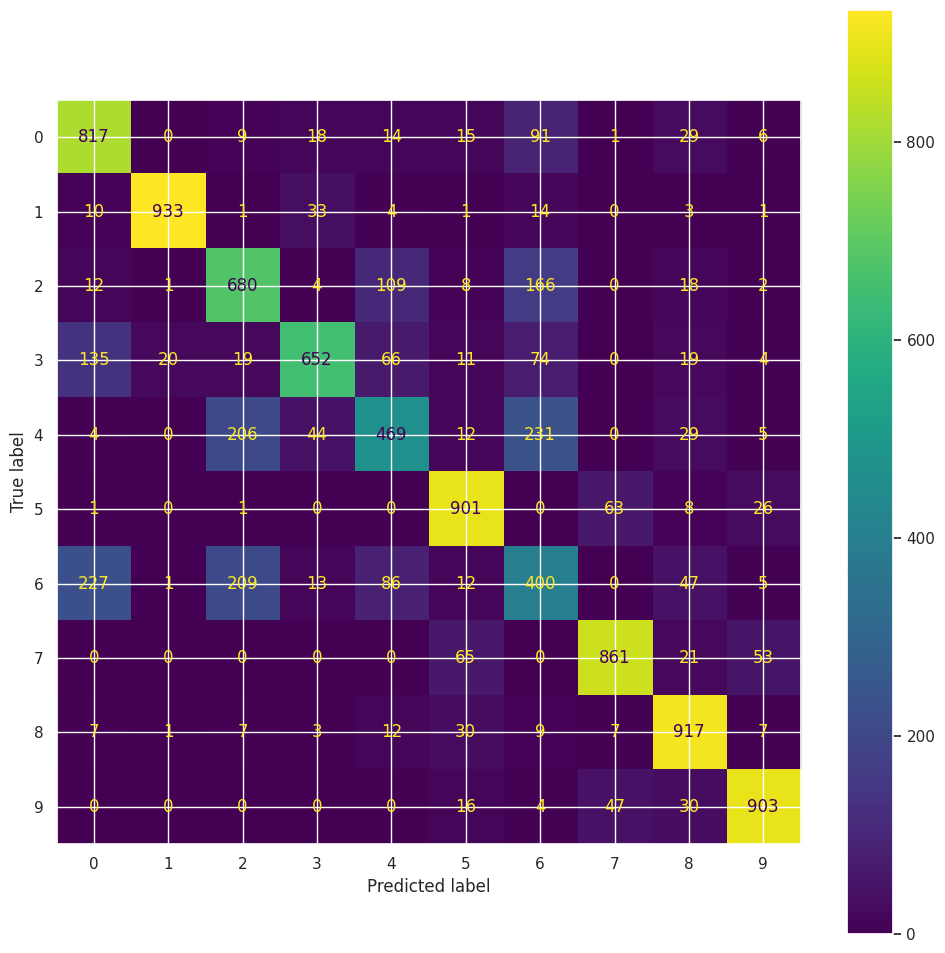

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(y_test, convert_predictions(predictions),ax=ax)
plt.show()

# Transfer Learning

So far, we have constructed a simple convolutional network, tuned it and improved its performance by exmapnding our dataset using the ImageDataGenerator class. Our final model is as strong as its feature extraction capabilities. We spent a considerable time tuing this and other parts of the model.

However, others have performed a similar set of steps and spent much much more time that what have spent so far tuning these feature extracting models. Why not use the fruit of their endeavors, as they have kindly shared them publically? :)

This technique is called transfer learning and as usualu, Keras provides a very nice and simple interface to use it in our models.

### VGG19 Model

In [ ]:
from keras.applications import VGG19

In [ ]:
def create_transfer_model(base_model,learning_rate=0.001,learning_rate_decay=0.9,no_classes=y_train_enc.shape[1]):
  model = Sequential()
  model.add(base_model)           #Adds the base model
  model.add(Flatten())
  model.add(Dense(128,activation=('relu')))
  model.add(Dropout(.2))
  model.add(Dense(no_classes,activation=('softmax')))

  model.compile(
          loss='categorical_crossentropy',
          optimizer= tf.keras.optimizers.Adam(lr=learning_rate,beta_1=learning_rate_decay),
          metrics=['accuracy'],
          )
  return model


### Using VGG19 & MobileNetV2 for Grayscale images
The VGG19 model architecture expects input images with three color channels (e.g., RGB), but we are trying to use it with `grayscale` images that have only one channel. VGG19 and many other pre-trained models are typically designed for color images with three channels (red, green, and blue).

To use VGG19 & MobileNetV2 with grayscale images, we'll need to preprocess the data by converting the single-channel grayscale images to three-channel grayscale images (with the same values in all three channels). We can do this by duplicating the single channel into three channels.

In [ ]:
base_model = VGG19(
    include_top=False,    # We do not include the top, because we just need the feature extraction layers
    weights='imagenet',
    input_shape=(32, 32, 3),  # Set the input shape to (28, 28, 3)
    classes=10)

# We make the weight non-trainable to reduce the number of weights in the network
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
def grayscale_to_rgb(images):
    """
    Convert grayscale images to pseudo-RGB images by repeating the single channel to three channels.

    Parameters:
    images (numpy array): Grayscale images with shape (batch_size, height, width, 1).

    Returns:
    rgb_images (numpy array): Pseudo-RGB images with shape (batch_size, height, width, 3).
    """
    rgb_images = np.repeat(images, 3, axis=-1)
    return rgb_images

In [ ]:
# Convert grayscale images to pseudo-RGB images
rgb_X_train = grayscale_to_rgb(resized_X_train)
rgb_X_test = grayscale_to_rgb(resized_X_test)

# Ensure that the image shape matches the input shape expected by VGG19 (224x224)
#rgb_images_resized = resize_images_to_vgg_input_shape(rgb_images)

# Use the VGG19 model with the RGB images
predictions = base_model.predict(rgb_X_test)


313/313 [==============================] - 4s 9ms/step


In [ ]:
model = create_transfer_model(base_model)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 20091338 (76.64 MB)
Trainable params: 66954 (261.54 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:
train_iterator = train_datagen.flow(rgb_X_train, y_train_enc,subset='training',batch_size=16)
val_iterator = train_datagen.flow(rgb_X_train, y_train_enc,subset='validation',batch_size=16)

In [ ]:
history = model.fit_generator(
      train_iterator,
      validation_data=val_iterator,
      callbacks=[early_stopping],
      steps_per_epoch=len(train_iterator),
      validation_steps=len(val_iterator),
      verbose=1,
      epochs=20,
)

Epoch 1/20
3000/3000 [==============================] - 58s 19ms/step - loss: 0.9082 - accuracy: 0.6711 - val_loss: 0.7851 - val_accuracy: 0.7119
Epoch 2/20
3000/3000 [==============================] - 56s 19ms/step - loss: 0.7544 - accuracy: 0.7230 - val_loss: 0.6901 - val_accuracy: 0.7430
Epoch 3/20
3000/3000 [==============================] - 54s 18ms/step - loss: 0.7262 - accuracy: 0.7330 - val_loss: 0.6715 - val_accuracy: 0.7578
Epoch 4/20
3000/3000 [==============================] - 56s 19ms/step - loss: 0.7024 - accuracy: 0.7424 - val_loss: 0.6847 - val_accuracy: 0.7512
Epoch 5/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.6959 - accuracy: 0.7455 - val_loss: 0.6532 - val_accuracy: 0.7538
Epoch 6/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.6829 - accuracy: 0.7471 - val_loss: 0.6384 - val_accuracy: 0.7660
Epoch 7/20
3000/3000 [==============================] - 55s 18ms/step - loss: 0.6740 - accuracy: 0.7489 - val_loss: 0.6308 -

In [ ]:
predictions = model.predict(rgb_X_test)
print('Weighted F1-Score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))

313/313 [==============================] - 3s 9ms/step
Weighted F1-Score is 0.80


In [ ]:
print('Top-2 Accuracy = %s' % top_k_accuracy_score(y_test, predictions, k=2))

Top-2 Accuracy = 0.9329


In [ ]:
import copy
model_vgg = copy.deepcopy(model)

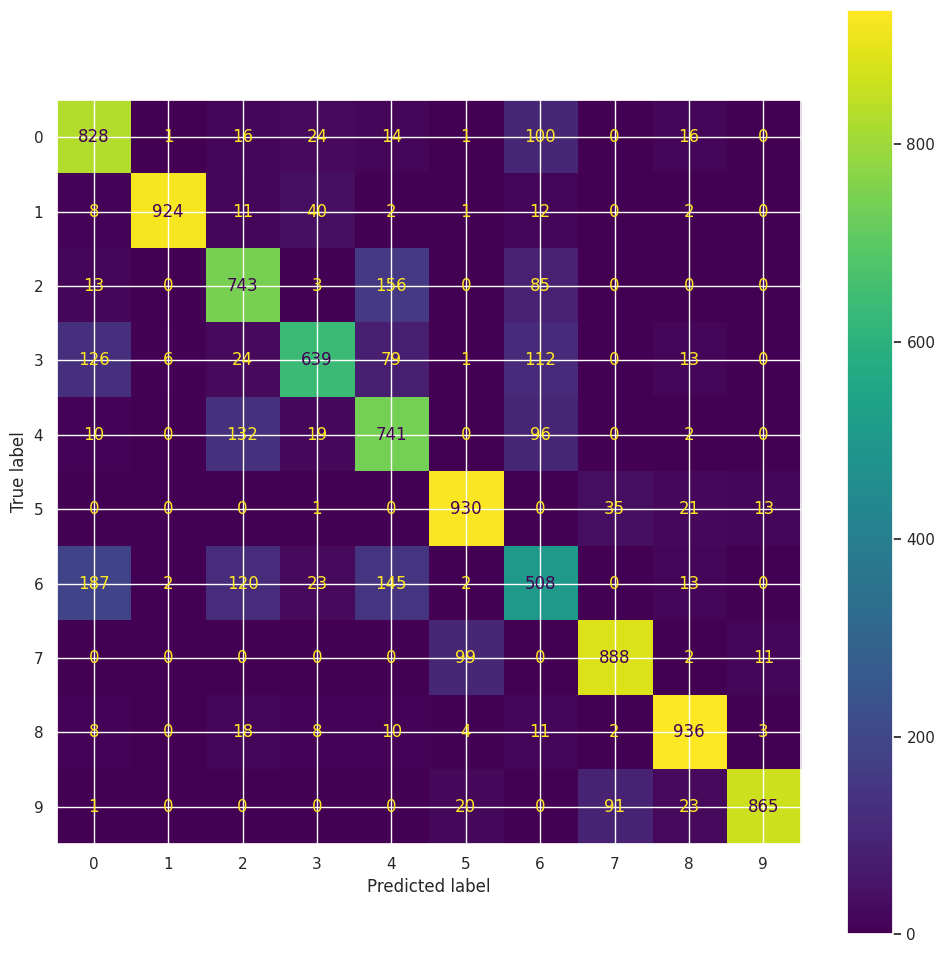

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(y_test, convert_predictions(predictions),ax=ax)
plt.show()

### MobileNetV2 Model

In [ ]:
from keras.applications import MobileNetV2

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,  # Exclude the top classification layers
    input_shape=(32, 32, 3),
    classes=10
)

# Set all layers in the base model to non-trainable
for layer in base_model.layers:
    layer.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model = create_transfer_model(base_model)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1, 1, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2423242 (9.24 MB)
Trainable params: 165258 (645.54 KB)
Non-trainable params: 2257984 (8.61 MB)
___________

In [ ]:
history = model.fit_generator(
      train_iterator,
      validation_data=val_iterator,
      callbacks=[early_stopping],
      steps_per_epoch=len(train_iterator),
      validation_steps=len(val_iterator),
      verbose=1,
      epochs=20,
)

Epoch 1/20
3000/3000 [==============================] - 75s 24ms/step - loss: 1.6987 - accuracy: 0.4035 - val_loss: 1.5890 - val_accuracy: 0.4402
Epoch 2/20
3000/3000 [==============================] - 65s 22ms/step - loss: 1.5705 - accuracy: 0.4402 - val_loss: 1.5472 - val_accuracy: 0.4529
Epoch 3/20
3000/3000 [==============================] - 69s 23ms/step - loss: 1.5323 - accuracy: 0.4582 - val_loss: 1.4911 - val_accuracy: 0.4732
Epoch 4/20
3000/3000 [==============================] - 59s 20ms/step - loss: 1.5100 - accuracy: 0.4634 - val_loss: 1.4777 - val_accuracy: 0.4683
Epoch 5/20
3000/3000 [==============================] - 58s 19ms/step - loss: 1.4988 - accuracy: 0.4643 - val_loss: 1.4472 - val_accuracy: 0.4833
Epoch 6/20
3000/3000 [==============================] - 64s 21ms/step - loss: 1.4942 - accuracy: 0.4701 - val_loss: 1.4615 - val_accuracy: 0.4822
Epoch 7/20
3000/3000 [==============================] - 71s 24ms/step - loss: 1.4744 - accuracy: 0.4748 - val_loss: 1.4428 -

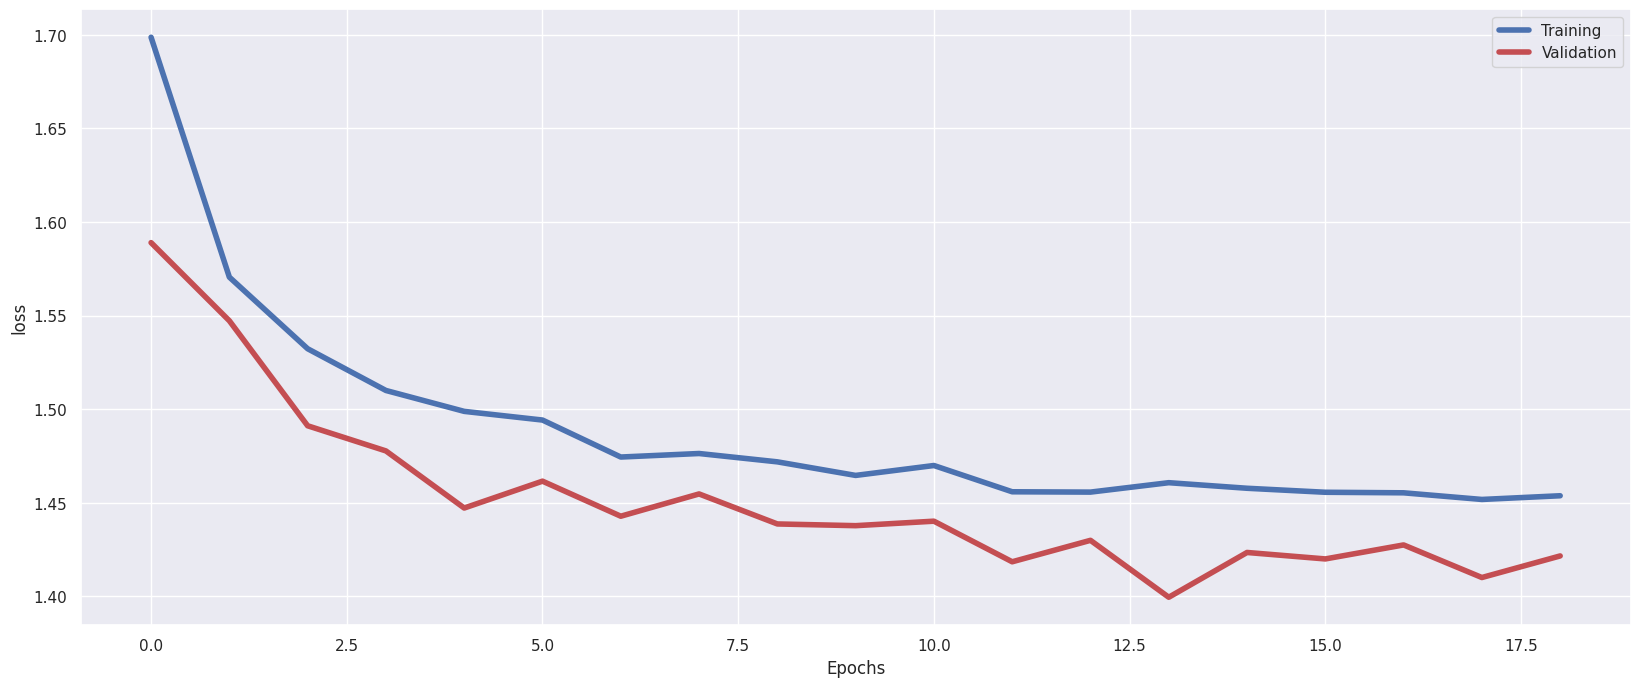

In [ ]:
plot_history(history,plot_type='loss')

In [ ]:
predictions = model.predict(rgb_X_test)
print('Weighted F1-Score is %.2f' %f1_score(y_test, convert_predictions(predictions), average='weighted'))

313/313 [==============================] - 4s 6ms/step
Weighted F1-Score is 0.59


In [ ]:
print('Top-2 Accuracy = %s' % top_k_accuracy_score(y_test, predictions, k=2))

Top-2 Accuracy = 0.7689


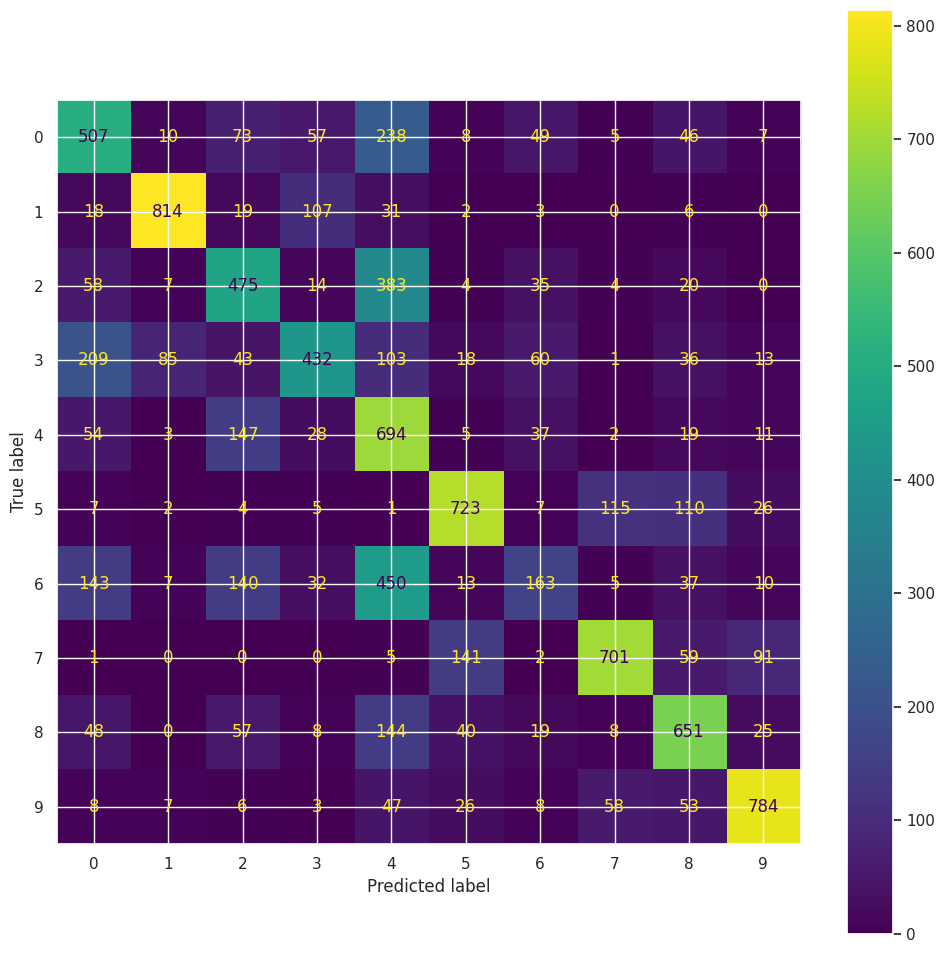

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(y_test, convert_predictions(predictions),ax=ax)
plt.show()

# Conceptual Question

Express you opinion about the effects of the window size (i.e. receptive field) in convolution layers on the performance of neural network. In other words, what happens if we increase or decrease the size of the receptive field? and Why?

The receptive field size directly impacts what features the network can capture and how it processes spatial information. Here's how changes in the receptive field size can affect neural network performance:


1.   **Smaller Receptive Field:**


*   **Advantages:** Smaller receptive fields focus on capturing fine-grained details and local patterns in the input data. They are suitable for tasks where small features are critical, such as edge detection, texture recognition, and object part localization.

*   **Disadvantages:** Networks with smaller receptive fields may struggle with capturing global context and understanding relationships between distant features. They may also be more sensitive to noise and small variations in the input.




2.   **Larger Receptive Field:**


*   **Advantages:** Larger receptive fields allow the network to capture more global information and context. They are beneficial for tasks that require understanding the overall structure, relationships between objects, and scene understanding. They are also robust to local noise.

*   **Disadvantages:** Networks with larger receptive fields may miss fine-grained details and may be less suitable for tasks where local patterns and small features are essential.





3.   **Hierarchical Receptive Fields:**

  In many deep convolutional neural networks, receptive fields are hierarchical, meaning that as you move deeper into the network, the receptive fields become larger. This arrangement allows the network to capture both local and global information progressively.

*   **Advantages:** This hierarchical approach combines the benefits of both small and large receptive fields. It starts with capturing local features and gradually integrates global context, making it suitable for a wide range of tasks.

*   **Disadvantages:** Designing networks with hierarchical receptive fields can be challenging and requires careful architecture design.



In summary, the choice of receptive field size should be guided by the specific requirements of the task at hand. Smaller receptive fields are suitable for tasks that depend on fine details, while larger receptive fields are better for tasks requiring global context. In practice, many modern convolutional neural networks, such as those used in image classification, object detection, and segmentation, incorporate a combination of small and large receptive fields through deep architectures to achieve a balance between local and global feature extraction.